In [2]:
# Importing all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import eXNN.topology
import json

import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Read preprocessed bike dataset
prep_bike_df = pd.read_csv('./bike_rental_hour.csv')

# Drop first two columns: instant has no any sence, dteday we can just ignore
prep_bike_df.drop('instant', axis=1, inplace=True)
prep_bike_df.drop('dteday', axis=1, inplace=True)
prep_bike_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [5]:
# Create a Full-Connected Neural Network class
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(MultiLayerPerceptron, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 120),
            # nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(120, 150),
            # nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(150, 140),
            # nn.BatchNorm1d(140),
            nn.ReLU(),
            nn.Dropout(0.23)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(140, 250),
            # nn.BatchNorm1d(250),
            nn.ReLU(),   
            nn.Dropout(0.23)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(250, 120),
            # nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.23)
        )
    
        self.layer6 = nn.Sequential(
            nn.Linear(120, output_dim),
            # nn.Sigmoid()
        )

    # Define forward loop for NN
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [6]:
# Define function for calculation RMSE
def root_mean_squared_error(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [7]:
# Define training and evaluating steps
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, epochs: int) -> None:
    train_losses = list()
    test_losses = list()
    rmse_scores = list()


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            all_outputs = list()
            all_targets = list()
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                all_outputs.append(outputs)
                all_targets.append(targets)

            test_loss /= len(test_loader)
            test_losses.append(test_loss)

            all_outputs = torch.cat(all_outputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            rmse_value = root_mean_squared_error(all_targets, all_outputs)
            rmse_scores.append(rmse_value)
        # scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, RMSE: {rmse_value:.4f}')

    # Loss and MAPE visualisation
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(rmse_scores, label='RMSE')
    plt.title('Loss and RMSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# Separate data into features and targets
X = prep_bike_df.iloc[:, :-1].values
y = prep_bike_df.iloc[:, -1].values
y = y.reshape(-1, 1)

# Data normalization
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, random_state=42)

# Convertation data to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.float32)    

# Creating DataLoader
train_data = TensorDataset(train_features, train_targets)
test_data = TensorDataset(test_features, test_targets)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

# Model initialization
model = MultiLayerPerceptron(14, 1)

# Define optimizator and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-05) #, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

Epoch 1/40, Train Loss: 0.0524, Test Loss: 0.0379, RMSE: 0.1942
Epoch 2/40, Train Loss: 0.0346, Test Loss: 0.0301, RMSE: 0.1731
Epoch 3/40, Train Loss: 0.0311, Test Loss: 0.0272, RMSE: 0.1645
Epoch 4/40, Train Loss: 0.0278, Test Loss: 0.0227, RMSE: 0.1504
Epoch 5/40, Train Loss: 0.0238, Test Loss: 0.0169, RMSE: 0.1296
Epoch 6/40, Train Loss: 0.0196, Test Loss: 0.0121, RMSE: 0.1097
Epoch 7/40, Train Loss: 0.0161, Test Loss: 0.0089, RMSE: 0.0939
Epoch 8/40, Train Loss: 0.0141, Test Loss: 0.0074, RMSE: 0.0858
Epoch 9/40, Train Loss: 0.0125, Test Loss: 0.0062, RMSE: 0.0789
Epoch 10/40, Train Loss: 0.0117, Test Loss: 0.0058, RMSE: 0.0764
Epoch 11/40, Train Loss: 0.0106, Test Loss: 0.0050, RMSE: 0.0709
Epoch 12/40, Train Loss: 0.0100, Test Loss: 0.0050, RMSE: 0.0707
Epoch 13/40, Train Loss: 0.0094, Test Loss: 0.0042, RMSE: 0.0649
Epoch 14/40, Train Loss: 0.0091, Test Loss: 0.0047, RMSE: 0.0685
Epoch 15/40, Train Loss: 0.0086, Test Loss: 0.0044, RMSE: 0.0662
Epoch 16/40, Train Loss: 0.0082, T

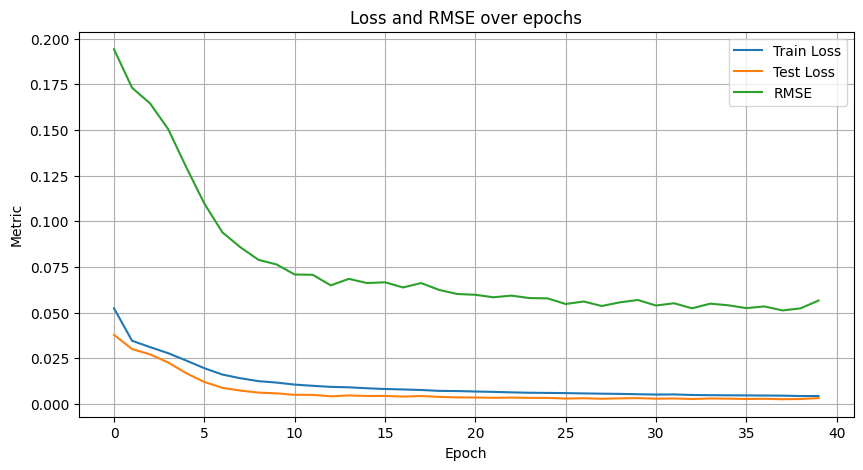

In [9]:
train_and_evaluate_model(model=model, train_loader=train_loader, test_loader=test_loader, criterion=criterion, optimizer=optimizer, epochs=40)